In [1]:
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
%matplotlib inline

/home/tomek/.virtualenvs/ib/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
multiplier = 25
min_tick = 0.25

In [3]:
periods = [10, 20, 40, 80, 160,] # 320] # number of periods for breakout rule
ema_fast = 80 # number of periods for moving average filter
sl_atr = 1 # stop loss in ATRs
atr_periods = 80 # number of periods to calculate ATR on
time_int = 15 # interval in minutes to be used to define volume candle

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

4957.834123352981

In [5]:
#vol_candles = group_by_time(contract, time_int)
vol_candles = group_by_volume(contract, avg_vol)
data = pd.DataFrame(vol_candles.close)
data['ema_fast'] = data.close.ewm(span=ema_fast).mean()

In [6]:
def get_ATR(data, periods):
    TR = pd.DataFrame({'A': (data['high'] - data['low']),
                       'B': (data['high'] - data['close']).abs(),
                       'C': (data['low'] - data['close']).abs()
                      })
    TR['TR'] = TR.max(axis=1)
    TR['ATR'] = TR['TR'].rolling(periods).mean()
    return TR.ATR

In [7]:
def get_min_max(data, period):
    return pd.DataFrame({
        'max': (data - data.shift(1).rolling(period).max()) > 0,
        'min': (data.shift(1).rolling(period).min() - data) > 0
    })

def majority_function(data):
    return (0.5 + ((data.sum(axis=1) - 0.5) / data.count(axis=1))).round(0)

def get_min_max_df(data, periods, func=get_min_max):
    min_max_func = partial(func, data)
    mins = pd.DataFrame()
    maxs = pd.DataFrame()
    for period in periods:
        df = min_max_func(period)
        mins[period] = df['min']
        maxs[period] = df['max']
    return {'min': mins,
           'max': maxs}

def get_signals(data, periods, func=get_min_max_df):
    min_max = func(data, periods)
    #return min_max['min']
    
    return pd.DataFrame({
        'signal': majority_function(min_max['max']) - majority_function(min_max['min'])
    })
  

In [8]:
signals = pd.DataFrame({
    'close': data.close,
    'signal': get_signals(data.close, periods)['signal']
})

In [9]:
signals['value'] = signals['close'] * signals['signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['buy'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['sell'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['cum_signal'] = signals.signal.expanding().apply(lambda x: x.sum().clip(min=-1, max=1), raw=False)

In [10]:
signals['filter'] = np.sign(data.close - data.ema_fast)
signals['atr'] = get_ATR(vol_candles, atr_periods)

In [11]:
number_of_trades = 0
entry = 0
for row in signals.itertuples():
    if row.Index == 0:
        continue
    # if there's no position signal is to be filtered
    if signals.loc[row.Index-1, 'cum_signal'] == 0 and row.filter * row.signal != 1:
        signals.loc[row.Index, 'cum_signal'] = 0
        continue
    else:
        signals.loc[row.Index, 'cum_signal'] = (signals.loc[row.Index-1, 'cum_signal'] + row.signal).clip(max=1, min=-1)
        
    # create stop loss
    if signals.loc[row.Index, 'cum_signal'] - signals.loc[row.Index-1, 'cum_signal'] != 0:
        sl = signals.loc[row.Index, 'close'] - signals.loc[row.Index, 'cum_signal'] * signals.loc[row.Index, 'atr'] * sl_atr
        signals.loc[row.Index, 'sl'] = sl
    if not signals.loc[row.Index, 'sl']:
        signals.loc[row.Index, 'sl'] = signals.loc[row.Index-1, 'sl']
        
    # apply stop loss
    if signals.loc[row.Index, 'cum_signal'] == 1 and signals.loc[row.Index, 'close'] < sl:
        signals.loc[row.Index, 'cum_signal'] = 0
    elif signals.loc[row.Index, 'cum_signal'] == -1 and signals.loc[row.Index, 'close'] > sl:
        signals.loc[row.Index, 'cum_signal'] = 0
        
    # count trades
    if signals.loc[row.Index, 'cum_signal'] != signals.loc[row.Index-1, 'cum_signal']:
        number_of_trades += 1

In [12]:
signals['value'] = signals['close'] * signals['cum_signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['long'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['short'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['long_pnl'] = signals.long.diff().fillna(0)
signals['short_pnl'] = - signals.short.diff().fillna(0)

In [13]:
long_pnl = signals.long_pnl.sum()
short_pnl = signals.short_pnl.sum()
pnl = long_pnl + short_pnl
long_pnl, short_pnl, pnl

(15961.75, 14445.75, 30407.5)

In [14]:
signals['pnl'] = signals['long_pnl'] + signals['short_pnl']
pnl_p = signals[signals['pnl']>0].pnl
pnl_m = signals[signals['pnl']<0].pnl
pnl_p.count(), pnl_m.count(), pnl_p.count()/(pnl_p.count()+pnl_m.count())

(16839, 13719, 0.551050461417632)

In [15]:
pnl_p.sum(), pnl_m.sum(), pnl_p.sum()/ pnl_m.abs().sum()

(105059.0, -74651.5, 1.4073260416736435)

In [16]:
pnl_m.sort_values().head(20)

label
10091   -65.00
31336   -60.25
10169   -59.00
44730   -49.00
10146   -47.75
10127   -41.50
46968   -40.50
31806   -39.50
10147   -38.00
20304   -37.75
24332   -35.75
10202   -35.50
10208   -34.50
10140   -34.25
14133   -33.50
13552   -33.00
10529   -33.00
24548   -32.50
30812   -32.25
13570   -32.00
Name: pnl, dtype: float64

In [17]:
pnl_p.sort_values(ascending=False).head(20)

label
29309    113.00
43179     88.50
10138     78.00
31335     55.25
45968     52.00
45237     47.75
46953     46.75
25993     45.00
15949     44.75
24552     44.25
10144     42.50
38995     41.75
10409     41.75
17712     41.00
31816     40.75
9944      40.25
26207     39.25
10088     39.25
31935     38.50
26001     38.50
Name: pnl, dtype: float64

In [18]:
signals['date'] = vol_candles['date']

In [19]:
signals.set_index('date', inplace=True)

In [20]:
signals.head(30)

,close,signal,value,buy,sell,cum_signal,filter,atr,sl,long,short,long_pnl,short_pnl,pnl
date,,,,,,,,,,,,,,
2017-05-05 19:25:00,5634.00,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.00,-0.0,0.00
2017-05-25 04:48:00,5755.75,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.00,-0.0,0.00
2017-06-02 15:30:00,5839.50,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.00,-0.0,0.00
2017-06-06 14:47:00,5877.25,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.00,-0.0,0.00
2017-06-07 15:13:00,5881.50,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.00,-0.0,0.00
2017-06-07 20:10:00,5883.75,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.00,-0.0,0.00
2017-06-08 11:10:00,5893.00,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.00,-0.0,0.00
2017-06-08 15:33:00,5895.25,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.00,-0.0,0.00
2017-06-08 15:42:00,5888.75,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.00,-0.0,0.00


In [21]:
daily = pd.DataFrame()
daily['close'] = signals['close'].resample('D').last()
daily['pnl'] = (signals['long_pnl'] + signals['short_pnl']).resample('D').sum()
daily.tail()

,close,pnl
date,,
2019-08-31,NaN,0.00
2019-09-01,NaN,0.00
2019-09-02,7623.25,-20.50
2019-09-03,7619.75,-10.00
2019-09-04,7697.25,89.75


In [22]:
daily.head()

,close,pnl
date,,
2017-05-05,5634.0,0.0
2017-05-06,NaN,0.0
2017-05-07,NaN,0.0
2017-05-08,NaN,0.0
2017-05-09,NaN,0.0


In [23]:
daily['dollars'] = 0
daily.iloc[0,2] = 15000

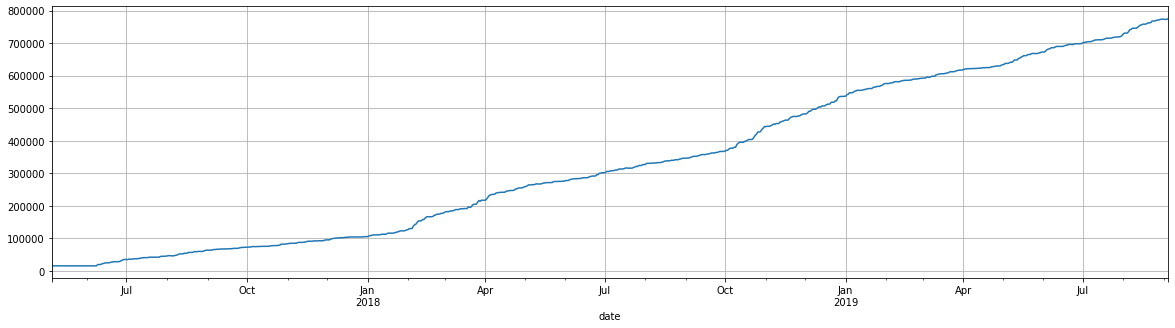

In [24]:
daily['dollars'] = 15000 + daily.pnl.cumsum() * multiplier
daily['return'] = daily.dollars.pct_change()
daily.dollars.plot(figsize=(20,5), grid=True);

In [25]:
daily.head(40)

,close,pnl,dollars,return
date,,,,
2017-05-05,5634.00,0.00,15000.00,NaN
2017-05-06,NaN,0.00,15000.00,0.000000
2017-05-07,NaN,0.00,15000.00,0.000000
2017-05-08,NaN,0.00,15000.00,0.000000
2017-05-09,NaN,0.00,15000.00,0.000000
2017-05-10,NaN,0.00,15000.00,0.000000
2017-05-11,NaN,0.00,15000.00,0.000000
2017-05-12,NaN,0.00,15000.00,0.000000
2017-05-13,NaN,0.00,15000.00,0.000000


In [26]:
daily.tail()

,close,pnl,dollars,return
date,,,,
2019-08-31,NaN,0.00,773706.25,0.000000
2019-09-01,NaN,0.00,773706.25,0.000000
2019-09-02,7623.25,-20.50,773193.75,-0.000662
2019-09-03,7619.75,-10.00,772943.75,-0.000323
2019-09-04,7697.25,89.75,775187.50,0.002903


In [27]:
daily['absolute'] = daily['pnl'] * multiplier/10000
daily.tail(20)

,close,pnl,dollars,return,absolute
date,,,,,
2019-08-16,7605.50,89.50,758562.50,0.002958,0.223750
2019-08-17,NaN,0.00,758562.50,0.000000,0.000000
2019-08-18,NaN,0.00,758562.50,0.000000,0.000000
2019-08-19,7720.50,76.75,760481.25,0.002529,0.191875
2019-08-20,7670.25,78.75,762450.00,0.002589,0.196875
2019-08-21,7757.25,-3.00,762375.00,-0.000098,-0.007500
2019-08-22,7708.50,39.25,763356.25,0.001287,0.098125
2019-08-23,7490.00,196.00,768256.25,0.006419,0.490000
2019-08-24,NaN,0.00,768256.25,0.000000,0.000000


In [28]:
perf_stats(daily['absolute'].iloc[40:])

Annual return          8.223369e+08
Cumulative returns     5.776285e+28
Annual volatility      2.204963e+00
Sharpe ratio           1.058882e+01
Calmar ratio           3.490024e+09
Stability              9.847367e-01
Max drawdown          -2.356250e-01
Omega ratio            2.662620e+01
Sortino ratio          9.491325e+01
Skew                   1.856380e+00
Kurtosis               4.226799e+00
Tail ratio             1.321983e+01
Daily value at risk   -1.851486e-01
dtype: float64

In [29]:
perf_stats(daily['return'].iloc[40:])

Annual return            2.019194
Cumulative returns      34.336182
Annual volatility        0.145784
Sharpe ratio             7.667203
Calmar ratio           139.421665
Stability                0.933528
Max drawdown            -0.014483
Omega ratio             20.370858
Sortino ratio           60.285043
Skew                     3.636064
Kurtosis                17.874123
Tail ratio              18.582960
Daily value at risk     -0.013932
dtype: float64

In [30]:
number_of_trades

4919

In [31]:
spread = min_tick * multiplier
commission = 1.18 + .85 
cost_of_trades = number_of_trades * (spread + commission)
cost_of_trades

40729.32

In [32]:
days = (daily.index[-1] - daily.index[0]).days #pd.to_datetime('20190613')).days
days

852

In [33]:
trades_per_day = number_of_trades / days
trades_per_day

5.773474178403756

In [34]:
pnl_in_dollars = pnl*multiplier

In [35]:
cost_of_trades / (pnl_in_dollars)

0.05357799227164351

In [36]:
mean = daily['return'].mean() * 252
std = daily['return'].std() * (252**.5)
mean, std

(1.1895011385422745, 0.20876829048817402)

In [37]:
mean/std

5.6977098186740935

In [38]:
#daily.to_pickle('nq_return.pickle')